In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Load the data
file_path = '/Users/peter/Public/Work Study/doj_newsrelease_scraped.csv' ## change this to the path of the file

def try_read_csv(file_path):
    encodings = ['utf-8', 'ISO-8859-1', 'cp1252']  # We can add more encodings if needed
    for i in encodings:
        try:
            return pd.read_csv(file_path, encoding=i)
        except UnicodeDecodeError as e:
            print(f"Failed with encoding {i}: {e}")
        except Exception as e:
            print(f"An error occurred: {e}")
    raise ValueError("Could not read the file with any of the provided encodings.")

data = try_read_csv(file_path)

In [4]:
df = data[data['tag_financialfraud'].notna()]
predict_df = data[data['tag_financialfraud'].isna()]

df = df[['text', 'tag_financialfraud', 'tag_securitiesfraud']]
predict_df = predict_df[['text', 'tag_financialfraud', 'tag_securitiesfraud']]

# Convert tags to a single label column
def label(row):
    if row['tag_financialfraud'] == 1:
        return 'financial_fraud'
    elif row['tag_securitiesfraud'] == 1:
        return 'securities_fraud'
    else:
        return 'no_fraud'

df['label'] = df.apply(label, axis=1)

# Manual mapping definition
manual_label_mapping = {
    'no_fraud': 0,
    'financial_fraud': 1,
    'securities_fraud': 2
}

df['label'] = df['label'].map(manual_label_mapping)
df['label'].value_counts()

label
0    112815
1     18125
2       926
Name: count, dtype: int64

In [5]:
# Separate majority and minority classes
df_majority = df[df['label'] == 0]  # no_fraud
df_minority_financial = df[df['label'] == 1]  # financial_fraud
df_minority_securities = df[df['label'] == 2]  # securities_fraud


from sklearn.utils import resample

# Undersample the majority class
df_majority_undersampled = resample(df_majority,
                                    replace=False,     # sample without replacement
                                    n_samples=len(df_minority_financial),  # match number in minority class
                                    random_state=42)  # reproducible results


df_minority_securities_oversample = resample(df_minority_securities,
                                    replace=True,     # sample without replacement
                                    n_samples=len(df_minority_financial),  # match number in minority class
                                    random_state=42)  # reproducible results

# Combine the majority class with undersampled minority classes
df = pd.concat([df_majority_undersampled, df_minority_financial, df_minority_securities_oversample])

# Shuffle the dataset to mix the classes
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['label'].value_counts()

label
1    18125
2    18125
0    18125
Name: count, dtype: int64

In [6]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)


# Reduce dataset size for faster debugging
train_text, _, train_labels, _ = train_test_split(train_text, train_labels, test_size=0.5, stratify=train_labels)
val_text, _, val_labels, _ = train_test_split(val_text, val_labels, test_size=0.9, stratify=val_labels)
test_text, _, test_labels, _ = train_test_split(test_text, test_labels, test_size=0.9, stratify=test_labels)


train_text = train_text.apply(str)  # Ensure all data is string type
val_text = val_text.apply(str)      # Ensure all data is string type
test_text = test_text.apply(str)    # Ensure all data is string type

In [7]:
# Load BERT model and tokenizer via HuggingFace Transformers
from transformers import AutoModel, BertTokenizerFast
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Text(0, 0.5, 'Number of texts')

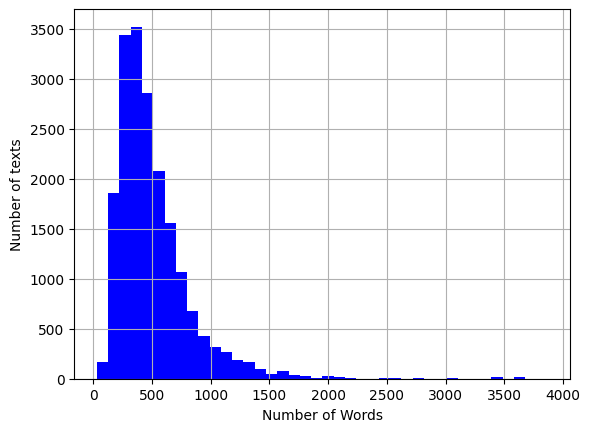

In [8]:
# Plot histogram of the number of words in train data 'text_release'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [9]:

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Majority of titles above have word length under 500. So, we set max title length as 300
MAX_LENGHT = 300
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [11]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 64                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [12]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,3)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Define accumulation steps
accumulation_steps = 8

def train():
    model.train()
    total_loss = 0
    optimizer.zero_grad()  # Reset gradients initially

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = cross_entropy(outputs, labels)
        total_loss += loss.item()
        
        # Normalize the loss to account for the accumulation steps
        loss = loss / accumulation_steps
        
        # Backward pass to calculate the gradients
        loss.backward()
        
        # Update parameters every `accumulation_steps`
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()  # Reset gradients after updating
    
    # If there are remaining steps that didn't hit the accumulation_steps
    if (step + 1) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

In [14]:

def evaluate():
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for step, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = cross_entropy(outputs, labels)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

In [30]:
# Train and predict
# You can skip this cell since I have already trained the model and saved it
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Training DOJ model3.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2


  0%|          | 0/298 [00:00<?, ?it/s]

100%|██████████| 13/13 [01:33<00:00,  7.17s/it]



Training Loss: 1.100
Validation Loss: 1.091

 Epoch 2 / 2


100%|██████████| 13/13 [01:37<00:00,  7.51s/it]



Training Loss: 1.087
Validation Loss: 1.080


In [31]:
#Load the model
model.load_state_dict(torch.load('Training DOJ model3.pt'))
model.eval()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [32]:
# Assuming you have already loaded your test data: test_seq, test_mask, and test_y
# Move test data to the device
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
test_y = test_y.to(device)

# Get predictions from the model
with torch.no_grad():
    logits = model(test_seq, test_mask)  # Get logits from the model

# Convert logits to probabilities using softmax
probabilities = torch.softmax(logits, dim=1)
probabilities = probabilities.cpu().numpy()  # Move probabilities to CPU and convert to numpy array

# Get the predicted class by taking the argmax
preds = np.argmax(probabilities, axis=1)

# Convert true labels to numpy array
true_labels = test_y.cpu().numpy()

# Print classification report
print(classification_report(true_labels, preds, target_names=['no_fraud', 'financial_fraud', 'securities_fraud']))

# Print confusion matrix
print(confusion_matrix(true_labels, preds))


                  precision    recall  f1-score   support

        no_fraud       0.52      0.55      0.53       272
 financial_fraud       0.43      0.08      0.14       271
securities_fraud       0.44      0.77      0.56       272

        accuracy                           0.47       815
       macro avg       0.46      0.47      0.41       815
    weighted avg       0.46      0.47      0.41       815

[[150  21 101]
 [ 86  23 162]
 [ 53  10 209]]


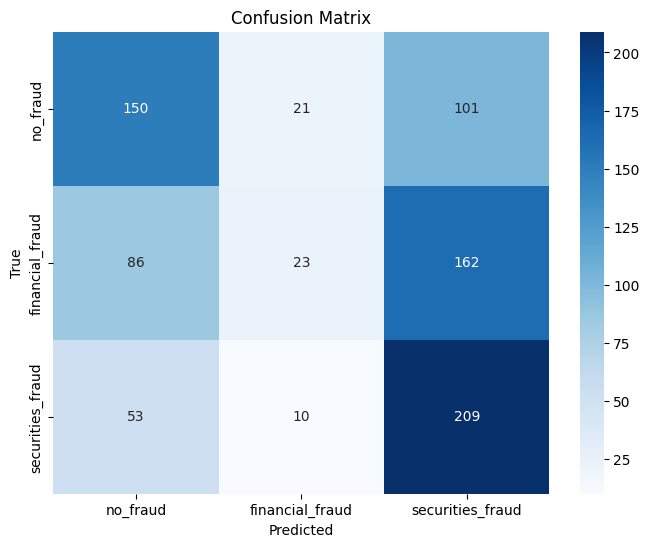

In [36]:

# Optionally, plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['no_fraud', 'financial_fraud', 'securities_fraud'], yticklabels=['no_fraud', 'financial_fraud', 'securities_fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Predictions

In [19]:
predict_df['label'] = predict_df.apply(label, axis=1)

# Manual mapping definition
manual_label_mapping = {
    'no_fraud': 0,
    'financial_fraud': 1,
    'securities_fraud': 2
}

predict_df['label'] = predict_df['label'].map(manual_label_mapping)
predict_df['label'].value_counts()

label
0    71370
Name: count, dtype: int64

In [22]:
# Ensure the text column is a list of strings
unseen_texts = predict_df['text'].dropna().tolist()
unseen_texts = [str(text) for text in unseen_texts]  # Convert all entries to string

MAX_LENGTH = 300  # Adjust as necessary

# Tokenize and encode new text data
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_texts,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)


In [ ]:
# Convert to tensors
unseen_seq = tokens_unseen['input_ids']
unseen_mask = tokens_unseen['attention_mask']

# Create DataLoader for unseen data
dataset = TensorDataset(unseen_seq, unseen_mask)
loader = DataLoader(dataset, batch_size=10)  # Adjust batch_size as needed

all_predictions = []

for batch in loader:
    input_ids, masks = batch
    input_ids = input_ids.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        logits = model(input_ids, masks)  # Get logits from the model
        probabilities = torch.softmax(logits, dim=1)  # Convert logits to probabilities for each class
        probabilities = probabilities.cpu().numpy()  # Move probabilities to CPU and convert to numpy array

        # Get the predicted class by taking the argmax
        preds = np.argmax(probabilities, axis=1)
        all_predictions.extend(preds)  # Collect all predictions

# Map predictions back to class names
label_mapping = {0: 'no_fraud', 1: 'financial_fraud', 2: 'securities_fraud'}
predicted_classes = [label_mapping[pred] for pred in all_predictions]

# Create a DataFrame to store predictions alongside the input texts
predictions_df = pd.DataFrame({'text': unseen_texts, 'predicted_class': predicted_classes})

# Print the predictions
for index, row in predictions_df.iterrows():
    print(f"Text: {row['text']}\nPredicted Class: {row['predicted_class']}\n")

# Optionally, save predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)